## Feature selection

Why would it even be necessary to select features? To some, this idea may seem counterintuitive, but there are at least two important reasons to get rid of unimportant features. The first is clear to every engineer: the more data, the higher the computational complexity. As long as we work with toy datasets, the size of the data is not a problem, but, for real loaded production systems, hundreds of extra features will be quite tangible. The second reason is that some algorithms take noise (non-informative features) as a signal and overfit.

### Statistical approaches

The most obvious candidate for removal is a feature whose value remains unchanged, i.e., it contains no information at all. If we build on this thought, it is reasonable to say that features with low variance are worse than those with high variance. So, one can consider cutting features with variance below a certain threshold.

#### Basado en estadísticos no supervisado

In [24]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification(random_state=2)
x_data_generated.shape

(100, 20)

In [25]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

(100, 20)

In [26]:
VarianceThreshold(.8).fit_transform(x_data_generated).shape

(100, 15)

In [27]:
VarianceThreshold(.9).fit_transform(x_data_generated).shape

(100, 14)

In [28]:
type(x_data_generated)

numpy.ndarray

In [29]:
x_data_generated[0]

array([-0.26623674,  1.578341  ,  0.24767631,  0.68782416, -1.84743373,
        0.9531774 , -0.34524196, -0.66518017,  0.7935246 , -0.03468537,
        0.83871299,  1.33239286,  0.45718852,  0.69619375,  0.14982795,
        0.39168286,  0.08027062, -0.17070155,  0.76586746, -2.1686185 ])

In [30]:
import pandas as pd
df = pd.DataFrame(x_data_generated, columns = ["col_{}".format(i) for i in range(1,21)])

In [31]:
df["y"] = y_data_generated

In [32]:
from matplotlib import pyplot as plt 

In [33]:
corr_matrix = df.corr()

In [34]:
corr_matrix.y.apply(lambda row: abs(row) > 0.25)

col_1     False
col_2      True
col_3      True
col_4     False
col_5     False
col_6     False
col_7     False
col_8     False
col_9     False
col_10    False
col_11    False
col_12    False
col_13    False
col_14    False
col_15    False
col_16    False
col_17    False
col_18    False
col_19    False
col_20    False
y          True
Name: y, dtype: bool

#### Basado en estadísticos supervisado

In [35]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

'''
f_classif realiza un test ANOVA
a técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930,
constituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre
la media de una variable continua. Es por lo tanto el test estadístico a emplear cuando se desea comparar las medias de
dos o más grupos. Esta técnica puede generalizarse también para estudiar los posibles efectos de los factores sobre la
varianza de una variable.
'''
x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)

In [36]:
logit = LogisticRegression(solver='lbfgs', random_state=17)

In [37]:
'''
log los es la distancia, o pérdida de info para los algoritmos de clasificación. Lo suyo es minimizarla

log_loss es una métrica que se trata de minimizar
neg_log_loss trata de maximizar. Existe ya que sklearn por lo general MAXIMIZA, es por ello
que intenta mantener sus funciones de maximiazación sin cambiar el código. Simplemente
le da la vuelta a la métrica.
'''
cross_val_score(logit, x_data_generated, y_data_generated, 
                scoring='neg_log_loss', cv=5).mean()

-0.38220361248066503

In [38]:
cross_val_score(logit, x_data_kbest, y_data_generated, 
                scoring='neg_log_loss', cv=5).mean()

-0.38750515759479676

In [39]:
cross_val_score(logit, x_data_varth, y_data_generated, 
                scoring='neg_log_loss', cv=5).mean()

-0.3665824650860544

We can see that our selected features have improved the quality of the classifier. Of course, this example is purely artificial; however, it is worth using for real problems.

### Selection by modeling

Another approach is to use some baseline model for feature evaluation because the model will clearly show the importance of the features. Two types of models are usually used: some “wooden” composition such as [Random Forest](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7) or a linear model with Lasso regularization so that it is prone to nullify weights of weak features. The logic is intuitive: if features are clearly useless in a simple model, there is no need to drag them to a more complex one.

#### Supervisado intrinseco

In [40]:
# Synthetic example

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()

rf = RandomForestClassifier(n_estimators=10, random_state=17)

# Se usa la media como umbral selector
pipe = make_pipeline(SelectFromModel(estimator=rf),
                     logit)

print(cross_val_score(logit, x_data_generated, y_data_generated, 
                      scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(rf, x_data_generated, y_data_generated, 
                      scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(pipe, x_data_generated, y_data_generated, 
                      scoring='neg_log_loss', cv=5).mean())

-0.4440899944524788
-0.3094669276549914
-0.3556167898296088


We must not forget that this is not a silver bullet again - it can make the performance worse.

In [41]:
from sklearn.preprocessing import StandardScaler

#x_data, y_data = get_data() 
x_data = x_data_generated
y_data = y_data_generated

pipe1 = make_pipeline(StandardScaler(), 
                      SelectFromModel(estimator=rf),
                      logit)

pipe2 = make_pipeline(StandardScaler(), logit)

print('LR + selection: ', cross_val_score(pipe1, x_data, y_data, 
                                          scoring='neg_log_loss', cv=5).mean())
print('LR: ', cross_val_score(pipe2, x_data, y_data, 
                              scoring='neg_log_loss', cv=5).mean())
print('RF: ', cross_val_score(rf, x_data, y_data, 
                              scoring='neg_log_loss', cv=5).mean())

LR + selection:  -0.3581477402291737
LR:  -0.44704165003807805
RF:  -0.3094669276549914


#### Supervisado wrapper

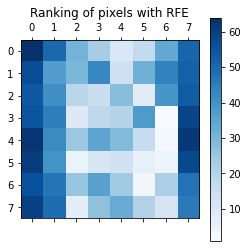

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

'''
Se escoge un estimador y un numero n de features. Se lanza el estimador con TODAS
las features y se calcula el "feature importance" de estimador. La peor feature se
elimina y se tira otro modelo con una feature menos, asi hasta alcanzar n
https://machinelearningmastery.com/rfe-feature-selection-in-python/
'''
# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
# SVC tiene coefs solo en el kernel lineal
svc = SVC(kernel="linear", C=1)

rfe = RFE(estimator=svc,
          n_features_to_select=1,
          step=1) # Features a eliminar en cada paso. 1 por defecto

rfe.fit(X, y)
'''
Ranking del 1 al 64, que son todos los pixeles.
rfe.support_ te da una mascara para filtrar luego las columnas
'''
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

In [13]:
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=10, step=1)
rfe.fit_transform(X, y)

array([[ 9., 11., 12., ...,  7., 12.,  6.],
       [13.,  6., 15., ...,  0.,  6.,  0.],
       [15., 16.,  1., ...,  0., 11.,  0.],
       ...,
       [15., 16.,  8., ...,  0., 16.,  2.],
       [ 7., 16., 16., ...,  2., 16.,  5.],
       [ 8., 15.,  5., ...,  6., 16.,  8.]])

#### Feature Selection with PCA, choosing the right number of features/dimensions

In [45]:
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

import numpy as np

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]


C:\Users\glezr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(

KeyboardInterrupt



In [70]:
X_train.shape

(60000, 784)

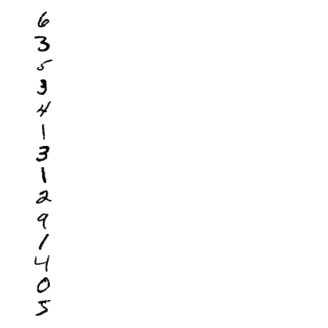

In [68]:

plt.figure(figsize=(7, 4))
row = 1
num_images = 14
for col in range(num_images):
    plt.imshow(X_train[col].reshape(28, 28), cmap="binary",
               vmin=0, vmax=255,  extent=(row, row + 1, col, col + 1))
    plt.axis([0, num_images,0, num_images])
    plt.axis("off")


In [71]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

In [72]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [73]:
pca.n_components_

154

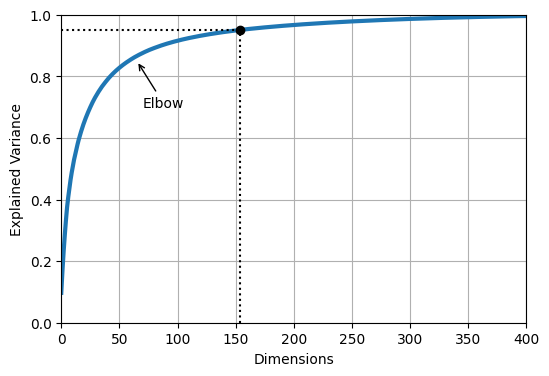

In [75]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [77]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [78]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [79]:
grid_search.best_params_

{'pca__n_components': 69}